In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [23]:
# market interest rate
risk_free_rate = 0.05

# we will consider monthly returns - and we want to calculate the annula return
months_in_year = 12

In [32]:
class CAPM:
    def __init__(self, stocks, start_date, end_date):
        self.data = None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date

    def download_data(self):
        data = {}

        for stock in self.stocks:
            ticker = yf.download(stock, self.start_date, self.end_date)
            # Adjusted Closing Price takes into account factors such as dividends, stock splits, etc.
            # Adjusted Closing Price is a more accurate reflection of the stock's value
            data[stock] = ticker['Adj Close']

        return pd.DataFrame(data)

    def initialize(self):
        stocks_data = self.download_data()
        # we use monthly returns ('M') instead of daily returns
        stocks_data = stocks_data.resample('M').last()

        # create a pandas dataframe to store stock information for analysis
        self.data = pd.DataFrame({'stock_adjclose':stocks_data[self.stocks[0]], 'market_adjclose':stocks_data[self.stocks[1]]})

        # add 2 columns for the s_returns and m_returns
        # logarithmic monthly returns
        self.data[['stock_returns', 'market_returns']] = np.log(self.data[['stock_adjclose', 'market_adjclose']] / self.data[['stock_adjclose', 'market_adjclose']].shift(1))

        # remove NaN values
        self.data =  self.data[1:]

        print(self.data)
        
    
    def calculate_beta(self):
        # covariance matrix: the diagonal items are teh variances
        # off diagonals are the covariances
        # the matrix is symmetric: cov[0,1] = cov[1,0]
        covariance_matrix = np.cov(self.data['stock_returns'], self.data['market_returns'])
        # calculating beta according to the formula
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
        print("Beta from formula: ", beta)

    def regression(self):
        # using linear regression to fit a line to the data
        # [stock_returns, market_returns] - slope is the beta
        beta, alpha = np.polyfit(self.data['market_returns'], self.data['stock_returns'], deg=1)
        # deg=1 linear line
        # deg=2 quadratic function to fit 
        # deg=3 cubic function to fit
        print("Beta from regression: ", beta)
        # calculate the expected return according to the CAPM formula
        # we are after annula return (this is why multiply by 12)
        expected_return = risk_free_rate + beta * (self.data['market_returns'].mean() * months_in_year - risk_free_rate)

        print("Expected return: ", expected_return)
        self.plot_regression(alpha, beta)

    def plot_regression(self, alpha, beta):
        fig, axis = plt.subplots(1, figsize=(20,10))
        axis.scatter(self.data['market_returns'], self.data['stock_returns'], label='Data Points')
        axis.plot(self.data['market_returns'], beta * self.data['market_returns'] + alpha, color='red', label='CAPM Line')
        plt.title('Capital Asset Pricing Model - Finding Alpha and Beta')
        plt.xlabel('Market return $R_m$', fontsize=18)
        plt.ylabel('Stock return $R_a$')
        plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha $', fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
            stock_adjclose  market_adjclose  stock_returns  market_returns
Date                                                                      
2010-02-28       88.244499      1104.489990       0.042697        0.028115
2010-03-31       89.000916      1169.430054       0.008535        0.057133
2010-04-30       89.521362      1186.689941       0.005831        0.014651
2010-05-31       87.371498      1089.410034      -0.024308       -0.085532
2010-06-30       86.129921      1030.709961      -0.014312       -0.055388
...                    ...              ...            ...             ...
2016-08-31      128.313599      2170.949951      -0.002293       -0.001220
2016-09-30      128.289398      2168.270020      -0.000189       -0.001235
2016-10-31      124.122078      2126.149902      -0.033023       -0.019617
2016-11-30      132.199585      2198.

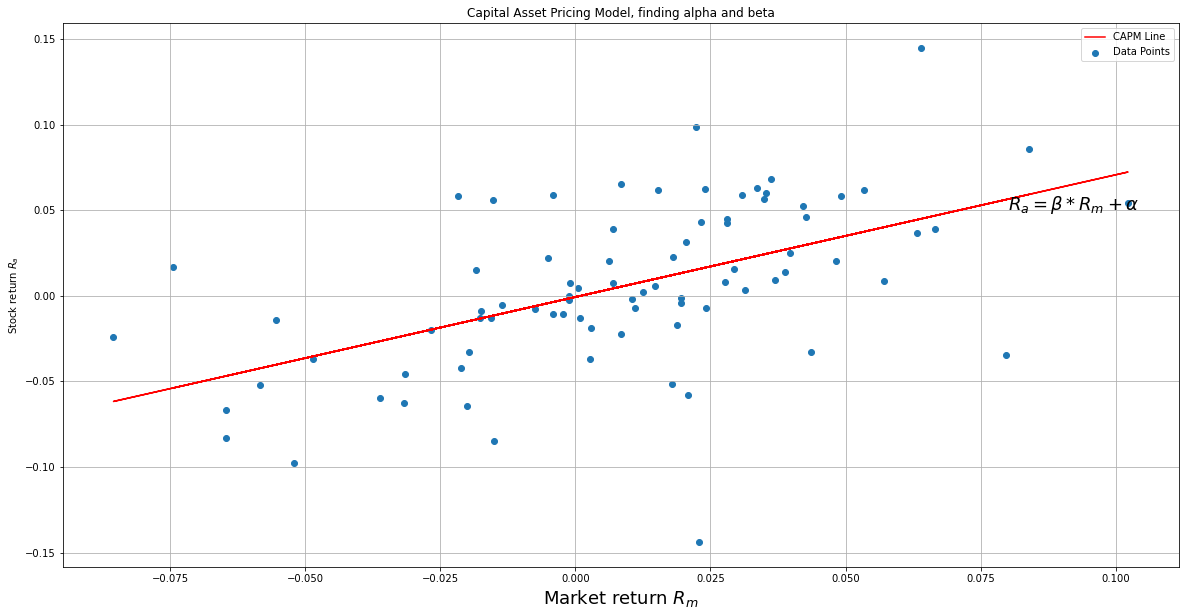

In [33]:
if __name__ == '__main__':
    capm = CAPM(['IBM', '^GSPC'], '2010-01-01', '2017-01-01')
    capm.initialize()
    capm.calculate_beta()
    capm.regression()